In [ ]:
import json
import os
import shutil
import time

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from google.colab import drive
from sklearn.metrics import classification_report, confusion_matrix
from timm.scheduler.cosine_lr import CosineLRScheduler
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm

# Configuration de l'affichage
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

In [2]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Copie des données du drive dans le disque local Colab
local_root_dir = "/tmp/MSTAR/"  # Un nouveau répertoire local
drive_root_dir = (
    "/content/drive/MyDrive/Dataset/PIE/SOC/"  # Supposons que ceci contient 'train' et 'test'
)

local_train_dir = os.path.join(local_root_dir, "train")
drive_train_dir = os.path.join(drive_root_dir, "train")

local_test_dir = os.path.join(local_root_dir, "test")
drive_test_dir = os.path.join(drive_root_dir, "test")


print("Début de la copie des données...")

# Vérifie si le répertoire local existe déjà
if os.path.exists(local_root_dir):
    shutil.rmtree(local_root_dir)  # Supprime l'ancien si nécessaire
os.makedirs(local_root_dir)  # Crée le répertoire racine

# Copie récursive de Drive vers le disque local /tmp (très rapide)
shutil.copytree(drive_train_dir, local_train_dir)
shutil.copytree(drive_test_dir, local_test_dir)

print("Copie terminée !")

Début de la copie des données...
Copie terminée !


In [ ]:
class Config:
    """Configuration centralisée pour l'entraînement"""

    # Chemins (à adapter à votre setup)
    train_dir = local_train_dir
    test_dir = local_test_dir
    save_dir = "/content/drive/MyDrive/PIE"  # Google Drive

    # Device
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Seed pour reproductibilité
    seed = 42


# Initialisation de la config
cfg = Config()

# Set seeds
torch.manual_seed(cfg.seed)
np.random.seed(cfg.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(cfg.seed)

print("🚀 Configuration:")
print(f"  Device: {cfg.device}")
print(f"  Model: {cfg.model_name}")
print(f"  Image size: {cfg.img_size}x{cfg.img_size}")
print(f"  Batch size: {cfg.batch_size}")
print(f"  Mixed Precision: {cfg.use_amp}")
print(f"  Epochs: {cfg.epochs}")

🚀 Configuration:
  Device: cuda
  Model: swin_tiny_patch4_window7_224
  Image size: 96x96
  Batch size: 32
  Mixed Precision: True
  Epochs: 10


In [5]:
def extract_patches_from_tensor(image_tensor, patch_size, stride, chip_size):
    """
    Extrait les patches MSTAR avec rognage central.

    Args:
        image_tensor: Tensor (C, H, W) ou (1, C, H, W)
        patch_size: Taille du patch (94)
        stride: Stride d'extraction (1)
        chip_size: Taille après rognage (100)

    Returns:
        patches: Tensor (N_patches, C, patch_size, patch_size)
    """
    if image_tensor.dim() == 3:
        image_tensor = image_tensor.unsqueeze(0)

    # Rogner au centre à chip_size (100x100)
    if image_tensor.size(2) > chip_size:
        start = (image_tensor.size(2) - chip_size) // 2
        image_tensor = image_tensor[:, :, start : start + chip_size, start : start + chip_size]

    # Extraction avec unfold
    patches_unfold = F.unfold(image_tensor, kernel_size=patch_size, stride=stride)

    # Reshape
    C = image_tensor.size(1)
    patches = patches_unfold.transpose(1, 2)
    patches = patches.reshape(-1, C, patch_size, patch_size)

    return patches


class AugmentedDataset(Dataset):
    """Dataset pour les patches augmentés"""

    def __init__(self, augmented_data):
        self.data = augmented_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


def create_augmented_dataset(dataset, cfg):
    """
    Applique l'augmentation par patches sur un dataset.

    Args:
        dataset: Dataset PyTorch
        cfg: Configuration

    Returns:
        AugmentedDataset avec tous les patches
    """
    print(f"🔄 Extraction des patches (patch_size={cfg.patch_size}, stride={cfg.stride})...")

    augmented_samples = []
    temp_loader = DataLoader(dataset, batch_size=1, shuffle=False)

    for images, labels in tqdm(temp_loader, desc="Patches"):
        images_squeeze = images.squeeze(0)
        all_patches = extract_patches_from_tensor(
            images_squeeze,
            patch_size=cfg.patch_size,
            stride=cfg.stride,
            chip_size=cfg.chip_size,
        )

        label = labels.item()
        for patch in all_patches:
            augmented_samples.append((patch, label))

    print("✅ Extraction terminée:")
    print(f"   Images originales: {len(dataset)}")
    print(f"   Patches générés: {len(augmented_samples)}")
    print(f"   Facteur d'augmentation: {len(augmented_samples) / len(dataset):.1f}x")

    return AugmentedDataset(augmented_samples)

In [6]:
# Transformations de base pour train (avant extraction patches)
train_transform_base = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
    ]
)

# Transformations pour validation/test (images complètes)
test_transform = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.CenterCrop(size=100),
        transforms.Resize(cfg.img_size),  # Resize à 96x96 pour Swin
        transforms.ToTensor(),
    ]
)

# Chargement datasets
full_train_dataset = ImageFolder(root=cfg.train_dir, transform=train_transform_base)
test_dataset = ImageFolder(root=cfg.test_dir, transform=test_transform)

# Récupération des noms de classes
class_names = full_train_dataset.classes
cfg.num_classes = len(class_names)

print(f"📊 Classes: {class_names}")
print(f"   Nombre de classes: {cfg.num_classes}")

# Split train/val AVANT augmentation (important!)
train_size = int((1 - cfg.val_split) * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset_base, val_dataset_base = random_split(
    full_train_dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(cfg.seed),
)

print("\n📦 Split initial:")
print(f"   Train: {len(train_dataset_base)} images")
print(f"   Val: {len(val_dataset_base)} images")
print(f"   Test: {len(test_dataset)} images")

# Augmentation par patches sur train
train_dataset_aug = create_augmented_dataset(train_dataset_base, cfg)

# Pour validation: soit patches aussi, soit images complètes
# Option 1 (recommandé): Patches sur val aussi pour cohérence
val_dataset_aug = create_augmented_dataset(val_dataset_base, cfg)

# DataLoaders
train_loader = DataLoader(
    train_dataset_aug,
    batch_size=cfg.batch_size,
    shuffle=True,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
    persistent_workers=True if cfg.num_workers > 0 else False,
)

val_loader = DataLoader(
    val_dataset_aug,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
    persistent_workers=True if cfg.num_workers > 0 else False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=cfg.batch_size,
    shuffle=False,
    num_workers=cfg.num_workers,
    pin_memory=cfg.pin_memory,
)

print("\n✅ DataLoaders créés:")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

📊 Classes: ['2S1', 'BMP2', 'BRDM2', 'BTR60', 'BTR70', 'D7', 'T62', 'T72', 'ZIL131', 'ZSU234']
   Nombre de classes: 10

📦 Split initial:
   Train: 2197 images
   Val: 550 images
   Test: 2425 images
🔄 Extraction des patches (patch_size=94, stride=1)...


Patches:   0%|          | 0/2197 [00:00<?, ?it/s]

✅ Extraction terminée:
   Images originales: 2197
   Patches générés: 107653
   Facteur d'augmentation: 49.0x
🔄 Extraction des patches (patch_size=94, stride=1)...


Patches:   0%|          | 0/550 [00:00<?, ?it/s]

✅ Extraction terminée:
   Images originales: 550
   Patches générés: 26950
   Facteur d'augmentation: 49.0x

✅ DataLoaders créés:
   Train batches: 3365
   Val batches: 843
   Test batches: 76


In [ ]:
print("\n" + "=" * 70)
print("🏗️  CONSTRUCTION DU MODÈLE")
print("=" * 70)


def create_swin_model(cfg):
    """
    Crée un modèle Swin Transformer adapté au SAR.

    Args:
        cfg: Configuration

    Returns:
        model: Swin Transformer
    """
    # Créer le modèle avec timm
    model = timm.create_model(
        cfg.model_name,
        pretrained=cfg.pretrained,
        num_classes=cfg.num_classes,
        img_size=cfg.img_size,
        in_chans=1,  # Grayscale SAR
        drop_rate=cfg.dropout,
        drop_path_rate=cfg.drop_path,
    )

    return model


# Création du modèle
model = create_swin_model(cfg).to(cfg.device)

# Affichage de l'architecture
try:
    from torchinfo import summary

    print(
        summary(
            model,
            input_size=(1, 1, cfg.img_size, cfg.img_size),
            device=cfg.device,
            verbose=0,
        )
    )
except ImportError:
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("\n📊 Paramètres du modèle:")
    print(f"   Total: {total_params:,}")
    print(f"   Trainable: {trainable_params:,}")


🏗️  CONSTRUCTION DU MODÈLE

📊 Paramètres du modèle:
   Total: 27,513,604
   Trainable: 27,513,604


In [ ]:
# Loss avec label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=cfg.label_smoothing)

# Optimizer AdamW (meilleur pour Transformers)
optimizer = optim.AdamW(
    model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay, betas=(0.9, 0.999)
)

# Scheduler avec warmup
num_steps = len(train_loader) * cfg.epochs
warmup_steps = len(train_loader) * cfg.warmup_epochs

scheduler = CosineLRScheduler(
    optimizer,
    t_initial=num_steps,
    lr_min=cfg.min_lr,
    warmup_t=warmup_steps,
    warmup_lr_init=1e-6,
    warmup_prefix=True,
)

# Mixed precision scaler
scaler = torch.amp.GradScaler(enabled=cfg.use_amp)

print("✅ Configuration:")
print(f"   Loss: CrossEntropyLoss (label_smoothing={cfg.label_smoothing})")
print(f"   Optimizer: AdamW (lr={cfg.lr}, wd={cfg.weight_decay})")
print(f"   Scheduler: Cosine avec warmup ({cfg.warmup_epochs} epochs)")
print(f"   Mixed Precision: {'Activé' if cfg.use_amp else 'Désactivé'}")

✅ Configuration:
   Loss: CrossEntropyLoss (label_smoothing=0.1)
   Optimizer: AdamW (lr=0.0001, wd=0.05)
   Scheduler: Cosine avec warmup (5 epochs)
   Mixed Precision: Activé


/tmp/ipython-input-2006016479.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=cfg.use_amp)


In [ ]:
class AverageMeter:
    """Calcule et stocke la moyenne et la valeur actuelle"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def train_epoch(model, loader, criterion, optimizer, scheduler, scaler, cfg, epoch):
    """Entraîne le modèle pour une époque"""
    model.train()

    losses = AverageMeter()
    accs = AverageMeter()

    pbar = tqdm(loader, desc=f"Epoch {epoch + 1}/{cfg.epochs} [Train]")
    for batch_idx, (images, labels) in enumerate(pbar):
        images, labels = images.to(cfg.device), labels.to(cfg.device)

        # Padding si nécessaire (94 -> 96)
        if images.size(-1) != cfg.img_size:
            pad = cfg.img_size - images.size(-1)
            images = F.pad(images, (0, pad, 0, pad), mode="constant", value=0)

        # Forward avec mixed precision
        with torch.cuda.amp.autocast(enabled=cfg.use_amp):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Scheduler step (par batch)
        scheduler.step_update(epoch * len(loader) + batch_idx)

        # Métriques
        acc = (outputs.argmax(1) == labels).float().mean()
        losses.update(loss.item(), images.size(0))
        accs.update(acc.item(), images.size(0))

        # Update progress bar
        pbar.set_postfix(
            {
                "loss": f"{losses.avg:.4f}",
                "acc": f"{accs.avg:.4f}",
                "lr": f"{optimizer.param_groups[0]['lr']:.2e}",
            }
        )

    return losses.avg, accs.avg


def validate(model, loader, criterion, cfg, desc="Val"):
    """Évalue le modèle"""
    model.eval()

    losses = AverageMeter()
    accs = AverageMeter()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        pbar = tqdm(loader, desc=f"[{desc}]")
        for images, labels in pbar:
            images, labels = images.to(cfg.device), labels.to(cfg.device)

            # Padding si nécessaire
            if images.size(-1) != cfg.img_size:
                pad = cfg.img_size - images.size(-1)
                images = F.pad(images, (0, pad, 0, pad), mode="constant", value=0)

            # Forward
            with torch.cuda.amp.autocast(enabled=cfg.use_amp):
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Métriques
            preds = outputs.argmax(1)
            acc = (preds == labels).float().mean()

            losses.update(loss.item(), images.size(0))
            accs.update(acc.item(), images.size(0))

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({"loss": f"{losses.avg:.4f}", "acc": f"{accs.avg:.4f}"})

    return losses.avg, accs.avg, np.array(all_preds), np.array(all_labels)

In [10]:
# Historique
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": [], "lr": []}

# Best model tracking
best_val_acc = 0.0
best_epoch = 0

# Timer
start_time = time.time()

for epoch in range(cfg.epochs):
    epoch_start = time.time()

    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scheduler, scaler, cfg, epoch
    )

    # Validation
    val_loss, val_acc, _, _ = validate(model, val_loader, criterion, cfg, "Val")

    # Scheduler epoch step
    scheduler.step(epoch + 1)

    # Sauvegarde historique
    current_lr = optimizer.param_groups[0]["lr"]
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)
    history["lr"].append(current_lr)

    # Temps
    epoch_time = time.time() - epoch_start

    # Affichage
    print(f"\n📊 Epoch {epoch + 1}/{cfg.epochs} - {epoch_time:.1f}s")
    print(f"   Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"   Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
    print(f"   LR: {current_lr:.2e}")

    # Sauvegarde du meilleur modèle
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch + 1

        checkpoint = {
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "scheduler_state_dict": scheduler.state_dict(),
            "val_acc": val_acc,
            "val_loss": val_loss,
            "config": vars(cfg),
        }

        torch.save(checkpoint, os.path.join(cfg.save_dir, "swin_best.pth"))
        print(f"   ✅ Nouveau meilleur modèle sauvegardé! (Val Acc: {val_acc:.4f})")

    # Sauvegarde périodique
    if (epoch + 1) % cfg.save_freq == 0:
        torch.save(checkpoint, os.path.join(cfg.save_dir, f"swin_epoch_{epoch + 1}.pth"))
        print(f"   💾 Checkpoint sauvegardé (epoch {epoch + 1})")

total_time = time.time() - start_time
print(f"\n✅ Entraînement terminé en {total_time / 60:.1f} minutes")
print(f"🏆 Meilleure Val Acc: {best_val_acc:.4f} (epoch {best_epoch})")

Epoch 1/10 [Train]:   0%|          | 0/3365 [00:00<?, ?it/s]

/tmp/ipython-input-426610855.py:36: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):


[Val]:   0%|          | 0/843 [00:00<?, ?it/s]

/tmp/ipython-input-426610855.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):



📊 Epoch 1/10 - 263.2s
   Train Loss: 1.9713 | Train Acc: 0.3051
   Val Loss: 1.4143 | Val Acc: 0.5860
   LR: 1.01e-06
   ✅ Nouveau meilleur modèle sauvegardé! (Val Acc: 0.5860)


Epoch 2/10 [Train]:   0%|          | 0/3365 [00:00<?, ?it/s]

[Val]:   0%|          | 0/843 [00:00<?, ?it/s]


📊 Epoch 2/10 - 262.8s
   Train Loss: 1.2904 | Train Acc: 0.6715
   Val Loss: 1.0853 | Val Acc: 0.7566
   LR: 1.01e-06
   ✅ Nouveau meilleur modèle sauvegardé! (Val Acc: 0.7566)


Epoch 3/10 [Train]:   0%|          | 0/3365 [00:00<?, ?it/s]

[Val]:   0%|          | 0/843 [00:00<?, ?it/s]


📊 Epoch 3/10 - 265.6s
   Train Loss: 1.0499 | Train Acc: 0.7843
   Val Loss: 0.9235 | Val Acc: 0.8250
   LR: 1.02e-06
   ✅ Nouveau meilleur modèle sauvegardé! (Val Acc: 0.8250)


Epoch 4/10 [Train]:   0%|          | 0/3365 [00:00<?, ?it/s]

[Val]:   0%|          | 0/843 [00:00<?, ?it/s]


📊 Epoch 4/10 - 265.1s
   Train Loss: 0.9165 | Train Acc: 0.8428
   Val Loss: 0.8415 | Val Acc: 0.8615
   LR: 1.02e-06
   ✅ Nouveau meilleur modèle sauvegardé! (Val Acc: 0.8615)


Epoch 5/10 [Train]:   0%|          | 0/3365 [00:00<?, ?it/s]

[Val]:   0%|          | 0/843 [00:00<?, ?it/s]


📊 Epoch 5/10 - 265.6s
   Train Loss: 0.8252 | Train Acc: 0.8864
   Val Loss: 0.7601 | Val Acc: 0.9050
   LR: 1.03e-06
   ✅ Nouveau meilleur modèle sauvegardé! (Val Acc: 0.9050)
   💾 Checkpoint sauvegardé (epoch 5)


Epoch 6/10 [Train]:   0%|          | 0/3365 [00:00<?, ?it/s]

[Val]:   0%|          | 0/843 [00:00<?, ?it/s]


📊 Epoch 6/10 - 263.0s
   Train Loss: 0.7589 | Train Acc: 0.9172
   Val Loss: 0.7183 | Val Acc: 0.9244
   LR: 1.04e-06
   ✅ Nouveau meilleur modèle sauvegardé! (Val Acc: 0.9244)


Epoch 7/10 [Train]:   0%|          | 0/3365 [00:00<?, ?it/s]

[Val]:   0%|          | 0/843 [00:00<?, ?it/s]


📊 Epoch 7/10 - 263.3s
   Train Loss: 0.7108 | Train Acc: 0.9384
   Val Loss: 0.6825 | Val Acc: 0.9408
   LR: 1.04e-06
   ✅ Nouveau meilleur modèle sauvegardé! (Val Acc: 0.9408)


Epoch 8/10 [Train]:   0%|          | 0/3365 [00:00<?, ?it/s]

[Val]:   0%|          | 0/843 [00:00<?, ?it/s]


📊 Epoch 8/10 - 262.0s
   Train Loss: 0.6739 | Train Acc: 0.9538
   Val Loss: 0.6470 | Val Acc: 0.9581
   LR: 1.05e-06
   ✅ Nouveau meilleur modèle sauvegardé! (Val Acc: 0.9581)


Epoch 9/10 [Train]:   0%|          | 0/3365 [00:00<?, ?it/s]

[Val]:   0%|          | 0/843 [00:00<?, ?it/s]


📊 Epoch 9/10 - 261.2s
   Train Loss: 0.6479 | Train Acc: 0.9638
   Val Loss: 0.6234 | Val Acc: 0.9658
   LR: 1.05e-06
   ✅ Nouveau meilleur modèle sauvegardé! (Val Acc: 0.9658)


Epoch 10/10 [Train]:   0%|          | 0/3365 [00:00<?, ?it/s]

[Val]:   0%|          | 0/843 [00:00<?, ?it/s]


📊 Epoch 10/10 - 260.7s
   Train Loss: 0.6270 | Train Acc: 0.9711
   Val Loss: 0.6052 | Val Acc: 0.9727
   LR: 1.06e-06
   ✅ Nouveau meilleur modèle sauvegardé! (Val Acc: 0.9727)
   💾 Checkpoint sauvegardé (epoch 10)

✅ Entraînement terminé en 44.5 minutes
🏆 Meilleure Val Acc: 0.9727 (epoch 10)


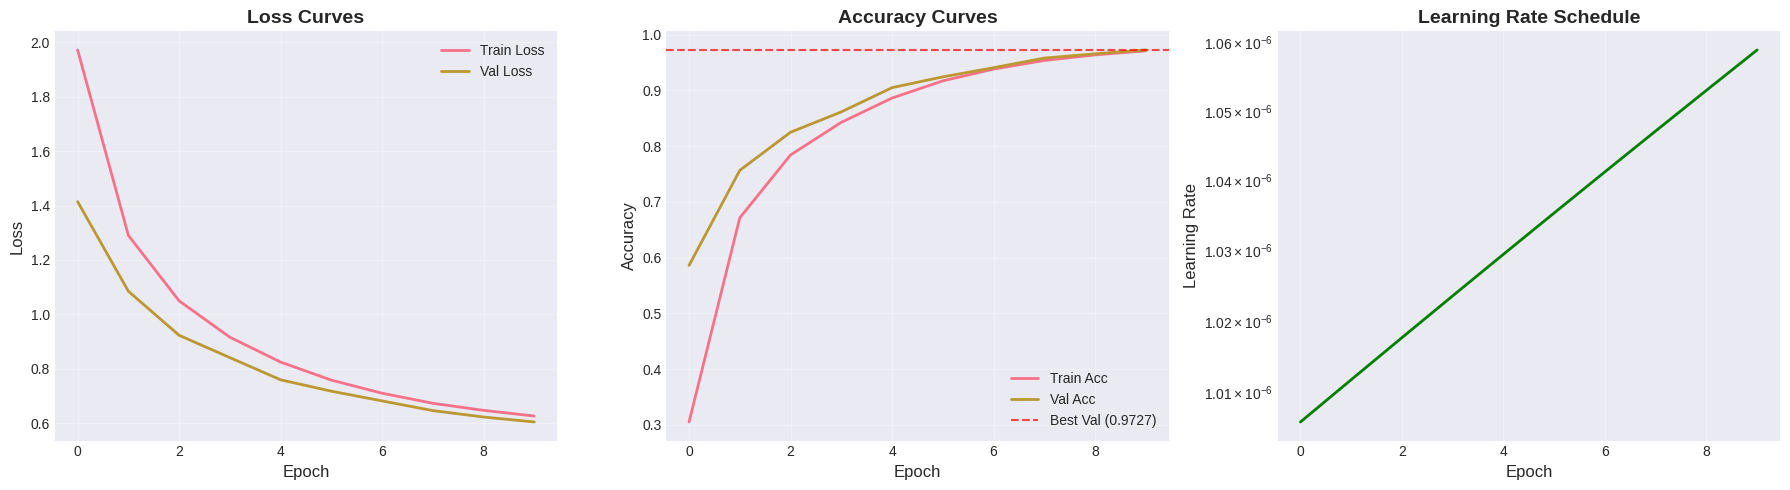

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(history["train_loss"], label="Train Loss", linewidth=2)
axes[0].plot(history["val_loss"], label="Val Loss", linewidth=2)
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("Loss", fontsize=12)
axes[0].set_title("Loss Curves", fontsize=14, fontweight="bold")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy
axes[1].plot(history["train_acc"], label="Train Acc", linewidth=2)
axes[1].plot(history["val_acc"], label="Val Acc", linewidth=2)
axes[1].axhline(
    y=best_val_acc,
    color="r",
    linestyle="--",
    label=f"Best Val ({best_val_acc:.4f})",
    alpha=0.7,
)
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("Accuracy", fontsize=12)
axes[1].set_title("Accuracy Curves", fontsize=14, fontweight="bold")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Learning Rate
axes[2].plot(history["lr"], linewidth=2, color="green")
axes[2].set_xlabel("Epoch", fontsize=12)
axes[2].set_ylabel("Learning Rate", fontsize=12)
axes[2].set_title("Learning Rate Schedule", fontsize=14, fontweight="bold")
axes[2].set_yscale("log")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(cfg.save_dir, "training_curves.png"), dpi=150)
plt.show()

In [12]:
# Charger le meilleur modèle
checkpoint = torch.load(os.path.join(cfg.save_dir, "swin_best.pth"))
model.load_state_dict(checkpoint["model_state_dict"])
print(f"✅ Meilleur modèle chargé (epoch {checkpoint['epoch']})")

# Évaluation
test_loss, test_acc, test_preds, test_labels = validate(model, test_loader, criterion, cfg, "Test")

print("\n📊 RÉSULTATS FINAUX:")
print(f"   Test Loss: {test_loss:.4f}")
print(f"   Test Accuracy: {test_acc:.4f} ({test_acc * 100:.2f}%)")

# Rapport de classification
print("\n" + "=" * 70)
print("Classification Report:")
print("=" * 70)
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

✅ Meilleur modèle chargé (epoch 10)


[Test]:   0%|          | 0/76 [00:00<?, ?it/s]

/tmp/ipython-input-426610855.py:84: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=cfg.use_amp):



📊 RÉSULTATS FINAUX:
   Test Loss: 0.9377
   Test Accuracy: 0.8214 (82.14%)

Classification Report:
              precision    recall  f1-score   support

         2S1     0.9846    0.9307    0.9568       274
        BMP2     1.0000    0.4667    0.6364       195
       BRDM2     0.8884    0.8139    0.8495       274
       BTR60     0.7566    0.8769    0.8124       195
       BTR70     0.9778    0.8980    0.9362       196
          D7     0.9535    0.5985    0.7354       274
         T62     1.0000    0.7326    0.8457       273
         T72     0.8326    0.9898    0.9044       196
      ZIL131     0.5141    1.0000    0.6791       274
      ZSU234     0.8714    0.8905    0.8809       274

    accuracy                         0.8214      2425
   macro avg     0.8779    0.8198    0.8237      2425
weighted avg     0.8761    0.8214    0.8239      2425



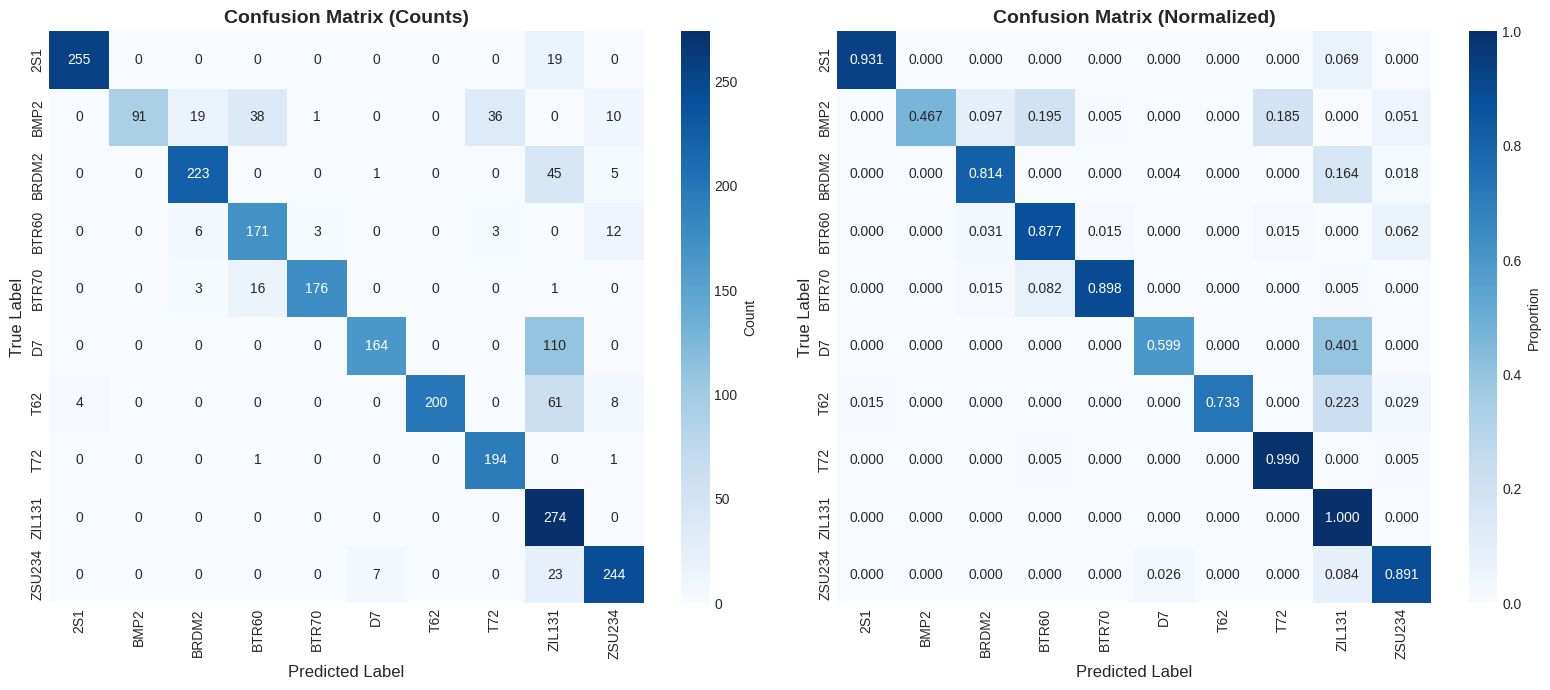


📊 Accuracy par classe:
   2S1       : 0.9307 (93.07%)
   BMP2      : 0.4667 (46.67%)
   BRDM2     : 0.8139 (81.39%)
   BTR60     : 0.8769 (87.69%)
   BTR70     : 0.8980 (89.80%)
   D7        : 0.5985 (59.85%)
   T62       : 0.7326 (73.26%)
   T72       : 0.9898 (98.98%)
   ZIL131    : 1.0000 (100.00%)
   ZSU234    : 0.8905 (89.05%)


In [14]:
# Calcul
cm = confusion_matrix(test_labels, test_preds)
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

# Visualisation
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Matrice brute
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[0],
    cbar_kws={"label": "Count"},
)
axes[0].set_title("Confusion Matrix (Counts)", fontsize=14, fontweight="bold")
axes[0].set_ylabel("True Label", fontsize=12)
axes[0].set_xlabel("Predicted Label", fontsize=12)

# Matrice normalisée
sns.heatmap(
    cm_normalized,
    annot=True,
    fmt=".3f",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axes[1],
    cbar_kws={"label": "Proportion"},
)
axes[1].set_title("Confusion Matrix (Normalized)", fontsize=14, fontweight="bold")
axes[1].set_ylabel("True Label", fontsize=12)
axes[1].set_xlabel("Predicted Label", fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(cfg.save_dir, "confusion_matrix.png"), dpi=150)
plt.show()

# Accuracy par classe
class_accs = cm_normalized.diagonal()
print("\n📊 Accuracy par classe:")
for i, class_name in enumerate(class_names):
    print(f"   {class_name:10s}: {class_accs[i]:.4f} ({class_accs[i] * 100:.2f}%)")


🔍 VISUALISATION DES ATTENTION MAPS


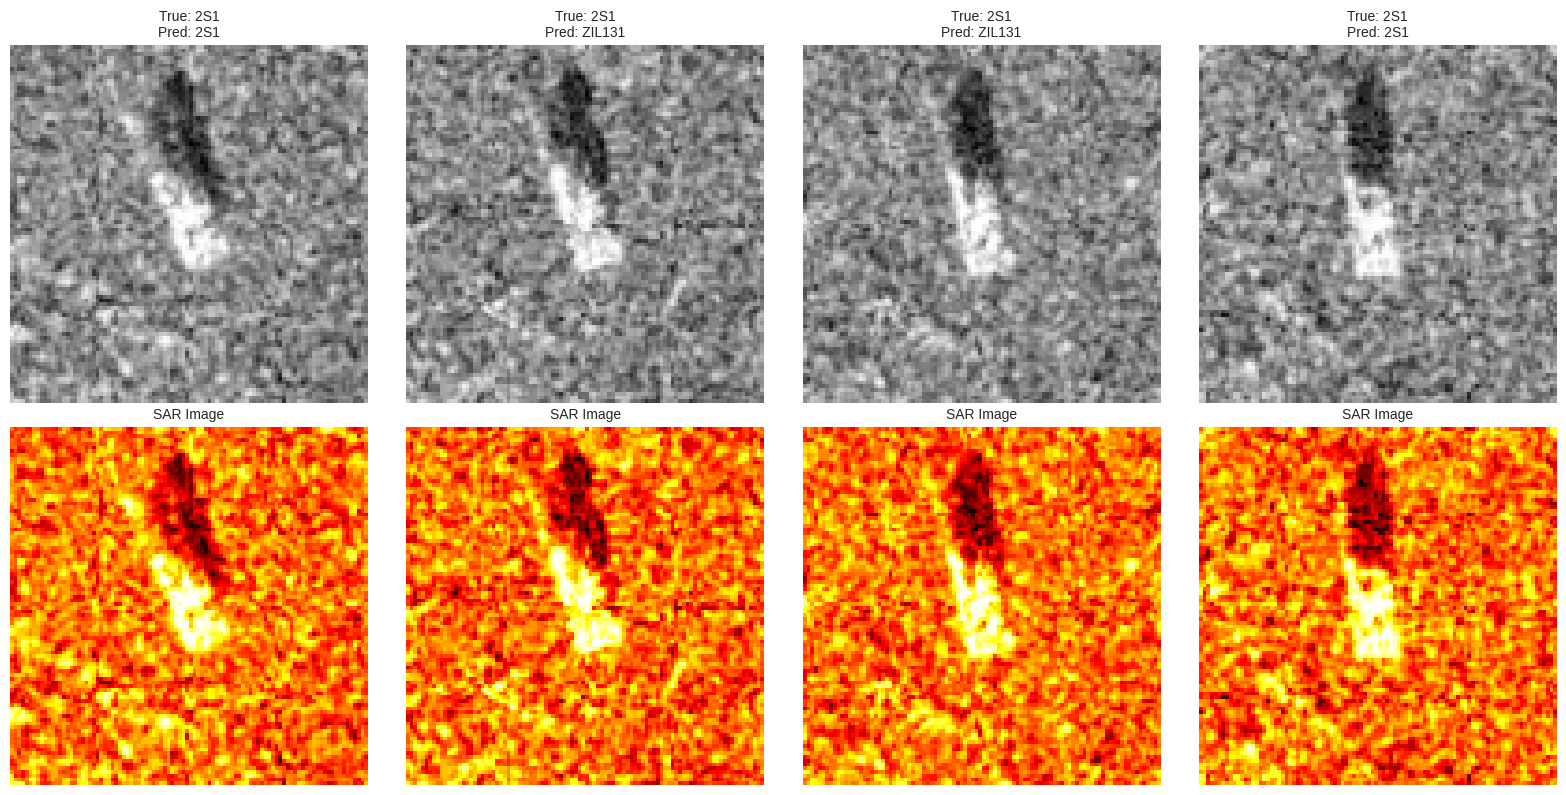

✅ Visualisations sauvegardées


In [15]:
print("\n" + "=" * 70)
print("🔍 VISUALISATION DES ATTENTION MAPS")
print("=" * 70)


def visualize_attention(model, dataloader, cfg, num_samples=4):
    """
    Visualise les attention maps de Swin Transformer.
    Note: Swin n'a pas d'attention globale mais des attention windows.
    """
    model.eval()

    # Récupérer quelques images
    images, labels = next(iter(dataloader))
    images = images[:num_samples].to(cfg.device)
    labels = labels[:num_samples]

    # Padding
    if images.size(-1) != cfg.img_size:
        pad = cfg.img_size - images.size(-1)
        images = F.pad(images, (0, pad, 0, pad), mode="constant", value=0)

    # Forward
    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(1)

    # Visualisation
    fig, axes = plt.subplots(2, num_samples, figsize=(4 * num_samples, 8))

    for i in range(num_samples):
        # Image originale
        img = images[i, 0].cpu().numpy()
        axes[0, i].imshow(img, cmap="gray")
        axes[0, i].set_title(
            f"True: {class_names[labels[i]]}\nPred: {class_names[preds[i]]}",
            fontsize=10,
        )
        axes[0, i].axis("off")

        # Grad-CAM approximation (simplifié)
        # Pour Swin, c'est plus complexe - ici on montre juste l'image
        axes[1, i].imshow(img, cmap="hot")
        axes[1, i].set_title("SAR Image", fontsize=10)
        axes[1, i].axis("off")

    plt.tight_layout()
    plt.savefig(os.path.join(cfg.save_dir, "sample_predictions.png"), dpi=150)
    plt.show()

    print("✅ Visualisations sauvegardées")


# Appeler la visualisation
try:
    visualize_attention(model, test_loader, cfg, num_samples=4)
except Exception as e:
    print(f"⚠️  Erreur visualisation: {e}")

In [16]:
# Sauvegarder l'historique et les métriques
results = {
    "config": vars(cfg),
    "history": history,
    "best_val_acc": best_val_acc,
    "best_epoch": best_epoch,
    "test_acc": test_acc,
    "test_loss": test_loss,
    "training_time_minutes": total_time / 60,
    "class_names": class_names,
    "confusion_matrix": cm.tolist(),
    "class_accuracies": class_accs.tolist(),
}

with open(os.path.join(cfg.save_dir, "results.json"), "w") as f:
    json.dump(results, f, indent=4)

print(f"\n✅ Résultats sauvegardés dans: {cfg.save_dir}")


✅ Résultats sauvegardés dans: /content/drive/MyDrive/PIE
